# Playground Script
### -- Moritz

### Libraries

In [84]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from torchvision.utils import draw_segmentation_masks
from torchvision.ops import masks_to_boxes
import torchvision.transforms.functional as F

import ultralytics
from ultralytics import YOLO
from ultralytics import settings

In [24]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### Notes

- Train test split:
    - Split: 70 / 20 / 10
    - => 1780 + 508 + 254 images and labels in train/test/split

### Draw Bounding Boxes

In [67]:
# Read in an image and its mask
IMAGE_DIRECTORY = "datasets/zenodo_data/bdappv/google"

img_path = os.path.join(IMAGE_DIRECTORY, "img/RWSLM293BPHSZ.png")
mask_path = os.path.join(IMAGE_DIRECTORY, "mask/RWSLM293BPHSZ.png")

img = read_image(img_path, mode=ImageReadMode.RGB)
mask = read_image(mask_path, mode=ImageReadMode.GRAY)

torch.Size([3, 400, 400])
torch.Size([1, 400, 400])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)


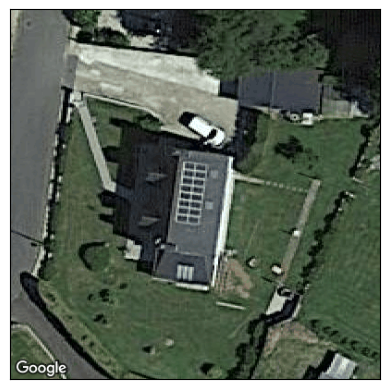

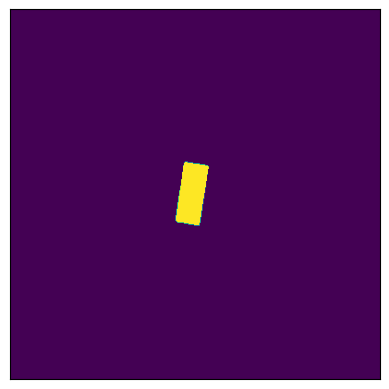

In [68]:
print(img.size())
print(mask.size())
print(mask)

show(img)
show(mask)

In [70]:
# We get the unique colors, as these would be the object ids.
obj_ids = torch.unique(mask)

# first id is the background, so remove it.
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set of boolean masks.
# Note that this snippet would work as well if the masks were float values instead of ints.
masks = mask == obj_ids[:, None, None]

In [71]:
print(masks.size())
print(masks)

torch.Size([1, 400, 400])
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])


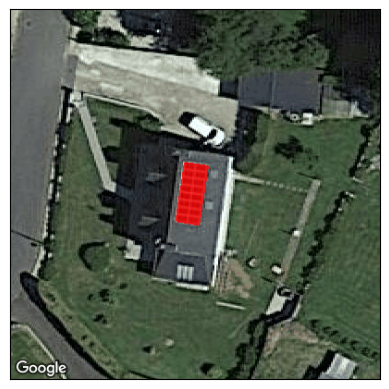

In [83]:
drawn_mask = draw_segmentation_masks(img, masks, alpha=0.8, colors="red")

show(drawn_mask)

### Convert Masks to Bounding Boxes

In [195]:
# Define image width and height
IMG_WIDTH = IMG_HEIGHT = 400

In [200]:
# Masks to bounding boxes
tensor_box = masks_to_boxes(mask)
box = tensor_box.numpy()[0] # transform to ndarray
box # (x1, y1, x2, y2) format

array([179., 165., 214., 233.], dtype=float32)

In [203]:
def bboxes_albumentations(bbox):
    bbox_normalized = np.empty(4, dtype="float")
    bbox_normalized[[1,3]] = bbox[[1,3]] / IMG_HEIGHT
    bbox_normalized[[0,2]] =  bbox[[0,2]] / IMG_WIDTH    
    return bbox_normalized

bbox_norm = bboxes_albumentations(box)
bbox_norm

array([0.44749999, 0.41249999, 0.53500003, 0.58249998])

In [204]:
def bboxes_yolo(bbox):
    x_center = ((bbox[0] + bbox[2])/2) / IMG_WIDTH
    y_center = ((bbox[1] + bbox[3])/2) / IMG_HEIGHT
    box_width = (bbox[2] - bbox[0]) / IMG_WIDTH
    box_height = (bbox[3] - bbox[1]) / IMG_HEIGHT

    bbox_yolo = (x_center, y_center, box_width, box_height)
    return bbox_yolo

bbox_yolo = bboxes_yolo(box)
bbox_yolo

(0.49125, 0.4975, 0.0875, 0.17)

In [254]:
mask_files = os.listdir("datasets/zenodo_data/bdappv/google/mask/")

try:
    os.makedirs("datasets/zenodo_data/bdappv/google/labels", exist_ok=False)
except OSError:
    pass


In [248]:
bbox_label = "0 " + ' '.join(map(str, bbox_yolo)) # add a class to the label

picture_ID = str.strip(mask_files[0], ".png")

label_path = "datasets/zenodo_data/bdappv/google/labels/" + picture_ID + ".txt"

with open(label_path, "w") as file:
    file.write(bbox_label)

In [278]:
mask_files = os.listdir("datasets/zenodo_data/bdappv/google/mask/")
try:
    os.makedirs("datasets/zenodo_data/bdappv/google/labels", exist_ok=False)
except OSError:
    pass

for i in range(0, len(mask_files)):

    mask_path = "datasets/zenodo_data/bdappv/google/mask/" + mask_files[i]
    mask = read_image(mask_path, mode=ImageReadMode.GRAY)

    tensor_box = masks_to_boxes(mask)
    box = tensor_box.numpy()[0] # transform to ndarray

    bbox_yolo = bboxes_yolo(box)

    bbox_label = "0 " + ' '.join(map(str, bbox_yolo)) # add a class to the label

    picture_ID = str.strip(mask_files[i], ".png")
    label_path = "datasets/zenodo_data/bdappv/google/labels/" + picture_ID + ".txt"
    with open(label_path, "w") as file:
        file.write(bbox_label)

    print(picture_ID)



QHIAP38B1OQXHG
SZZQN3153ISEHU
ZAZKP480AECPIL
OSQWT6597BAQBV
KIKQD56BCFFUIB
ABVBD7890XFZRO
GZOAT328IGAPW
ODRMF45D7JYPQI
PZXEH10E5RMDWM
EXTBL2A8EAYTGN
UDNPA4159WLEJP
SPUYG9B4EYDXDT
GZXLT6432VJMDV
KKOXY215AEYPDX
CQUGN5379ILRHR
EIUXI5BC7WUWSC
DXBKF267EVCEYZ
VUEQH44D7PUWRP
JUVHB6E50CUVJM
ORCXY6192RBEYQ
GTCCB1305TGWPU
CBBBP332CMACFE
RNJIA755AOQIWA
CQODD2ED7MPGVT
RHLAB41FEOWZS
YGNPQ3B8BHCMPA
RERTJ2C05QEMEC
KUJID7E74BRBIK
PAPWJ5EA9FFGFZ
GUMSK3603IDTAJ
YABCV2D6EKVDBF
CSUEX77A7LAPJJ
FFJSJ7C29IAALT
LRRLY47DAGZXDW
GRJGZ3C2EKQIQG
ZXIJP39A5NOGLP
RWNEK7822YKSVP
YZUWV7E39HUIJB
JFMZR3639PIXWY
NEGHD15D4NKKEV
SANYS37C6ZPFJE
XKNZA4ED4HHRRA
LLWWT7DDAMBMEV
ZRAPL4CAFURONO
XURNI3936GJOBQ
PEFLA8BA8ERLEC
TEBPI6CA5ZPOMD
BVNCL4975WALTK
YHKWX16C7QHFMB
DTWRP3A6DNAJRH
XHVNN7510ZUFZK
ZVNRE7233UCIXK
YFEYQ7A5EGINRC
RPART65F5TJTCJ
GWHFR54FDPZJIH
THRJF44A6RHKKN
GVIBW784FCYIP
SUGSK2E20BXCWP
WBITJ6ACOBYRX
NLVNK509DXWXTK
GHVDM5AF1RRQNH
PEDWM1D8AOQKTA
OTCCJ6739GXDRL
CJAJP2B0CMJDJE
ISDEC6499LLFQU
RDNJZ807AUDIJU
CMMWR4809YYRAD

### YOLOv8 Predictions

In [4]:
ultralytics.checks()

Ultralytics YOLOv8.0.232 🚀 Python-3.11.5 torch-2.1.2 CPU (Apple M2)
Setup complete ✅ (8 CPUs, 8.0 GB RAM, 406.1/460.4 GB disk)


In [5]:
# Load the trained YOLOv8 model downloaded from Colab
model = YOLO("downloaded_models/yolov8_medium_20e/weights/best.pt")

In [6]:
# Define path to the image file
img_source = "datasets/maxar_solar/val/images/*.tif"

# Run inference on 'bus.jpg' with arguments
# model.predict(img_source, save=True, imgsz=416, conf=0.5)